In [1]:
# IPython ~~~ Magic ~~~
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Exploring Metrics and Rewards

In this notebook, we'll explore how some particular functions are built. The first is the stochastic similiarity metric function. This was used to measure how close the actions being chosen were to the samples from expert matches. The next reward function is an adjusted probability reward. This was used in the hierarchial single agent model to measure the probability of the action chosen by lower level models matches with the distribution created from the higher level signal.

## Stochastic Similarity using Hidden Markov Models [1]

Observations generated by humans are generally complex and can be further obfuscated by its multidimensionality. In the Toribash problem, the observations, matches played by humans, are represented by position and velocity vectors. To measure how similar a generated match is with a set of expert matches use a Hidden Markov Model. More specifically, measure the stochastic similiarty between two observations based on a Hidden Markov Model that assumes no _a priori_ knowledge about the set of observations.  

### Hidden Markov Model

A Hidden Markov Model (HMM) allows us to reason about the probability of a given sequence of observations under the dynamics of hidden factors. We'll define an HMM, H, as the tuple $(\lambda, Q, \Pi, O) $ 


$$ \lambda = (A, B) \text{ are the transition and emission probabilities of the HMM }$$
$$ Q = q_1, q_2, . . . q_T \text{ is the set of hidden states of the HMM }$$
$$ \Pi = \pi_1, \pi_2, . . . \pi_T \text{ is the distribution of starting probabilities} $$
$$ O = o_1, o_2, . . . o_T \text{ is the set of observations over which the HMM is locally optimal} $$



$\lambda$ is an automaton where A is a matrix of transition probabilites such that $a_{ij} = P(q_{t+1} = j | q_t = i)$ and B is a matrix of emission probabilies such that $b_i(o_t)$ is the probability of observing $o_t$ if the current state is at i i.e. $q_t = i$. 

### Stochastic Similarity

We can learn the parameters of the HMM (A,B) using the forward-backward/Baum-Welch algorithms and then use the HMM to measure $P(O | \lambda)^1$ for a given sequence. [1] extends this type of analysis to measure equivalence of two HMMs where $\lambda_1 \sim \lambda_2$ iff:

$$ P(O | \lambda_1) = P(O | \lambda_2) \quad\quad  \forall O$$

<br>
<br>

If we have sequences $O_1$ and $O_2$ where we want to measure their similiarty $\sigma(O_1, O_2)$, we first train their respective HMM's $\lambda_1$ and $\lambda_2$. Then, let $P_{ij}$ be the probability of observation _i_ given HMM _j_. This defines $\sigma$ as the following: 

$$
\sigma(O_1, O_2) = \sqrt{\frac{ P_{12}P_{21} }{ P_{11}P_{22} }}
$$


1.) The paper defines the HMM as $\lambda$ while here we define $\lambda$ as the automaton describing the HMM. 

In [27]:
# Let's try implementing this measure using hmmlearn!
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("..")


from copy import deepcopy
from scipy import stats
from os.path import join
from sklearn import linear_model
from utils.tools import *
from utils.viz_tools import visuals
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import ShuffleSplit, train_test_split
from hmmlearn import hmm # <-- library to train and use hmm's with numpy arrays


plt.style.use("ggplot")

In [25]:
def lengths_to_idx(lengths):
    idx = [0]
    for l in lengths:
        idx.append(idx[-1] + l)
    return np.array(idx[1:-1]).astype(np.int)

In [28]:
"""
The paper uses a codebook to discretize the state space. We follow a similar algorithm, but we use PCA to reduce the dimensionality 
first and then use K-Means clusters as our codebook 
"""

 # load up the expert trajectories
df1 = load_csv(join(sys.path[0], "../data/player1_state_info.csv"))
df2 = load_csv(join(sys.path[0], "../data/player2_state_info.csv"))
p1 = df1.drop(columns=['Unnamed: 0', 'match', 'turn'])
p2 = df2.drop(columns=['Unnamed: 0', 'match', 'turn']) 
df1['match_length'] = 1
func = {'match_length': lambda l: sum(l)}
gb = df1.groupby(by='match').agg(func)

# get the indicies by match length
lengths = list(gb.match_length)
expert_idx = lengths_to_idx(lengths)

experts = np.concatenate((p1, p2), axis=1)

In [38]:
# transform the data with the codebook (learned K-Means clustering)
pca = PCA(30)
kmeans = KMeans(10)
reduced_obs = pca.fit_transform(experts)
codebook = kmeans.fit_predict(reduced_obs).reshape((-1,1))

In [41]:
expert_observations = np.split(codebook, expert_idx)

In [40]:
hmm1 = hmm.GaussianHMM(12, n_iter = 50, verbose = True).fit(codebook, lengths)
hmm2 = hmm.GaussianHMM(12, n_iter = 50, verbose = True).fit(codebook, lengths)

         1     -128921.2136             +nan
         2      -83875.8907      +45045.3229
         3        9868.7372      +93744.6279
         4      222779.5849     +212910.8478
         5      273824.2119      +51044.6269
         6      277301.9965       +3477.7846
         7      278327.1682       +1025.1717
         8      279262.2117        +935.0435
         9      279571.1896        +308.9778
        10      279575.1915          +4.0020
        11      279575.1954          +0.0039
         1     -128921.2136             +nan
         2      -83875.8907      +45045.3229
         3        9868.7372      +93744.6279
         4      222779.5849     +212910.8478
         5      273824.2119      +51044.6269
         6      277301.9965       +3477.7846
         7      278327.1682       +1025.1717
         8      279262.2117        +935.0435
         9      279571.1896        +308.9778
        10      279575.1915          +4.0020
        11      279575.1954          +0.0039


In [44]:
samples1_idx = np.random.choice(np.arange(len(lengths)), size=(10,), replace=True)
samples2_idx = np.random.choice(np.arange(len(lengths)), size=(10,), replace=True)
sim_score = []       
for i,j in list(zip(samples1_idx, samples2_idx)):
    obs1 = expert_observations[i]
    obs2 = expert_observations[j]
    P11 = 10**(hmm1.score(obs1)/len(obs1))
    P12 = 10**(hmm1.score(obs2)/len(obs2))
    P21 = 10**(hmm2.score(obs1)/len(obs1))
    P22 = 10**(hmm2.score(obs2)/len(obs2))

    sim_score.append(np.sqrt((P12*P21)/(P11*P22)))

print(sum(sim_score)/len(sim_score))

1.0


Here, we split the trajectories of the expert trajectories just for the example. The score let's us know how similar the two trained HMM's are. When $\sigma(O_1, O_2) = 1$, then that implies that $\lambda_1 \sim \lambda_2$ [1]. Thus, the closer to one the similarity score is, the greater the likelihood that the two HMM's are the same. In the example above, we used exactly the same set of observations (the experts) and obtained a results of 1 over 10 different sets of samples. This is promising because that means we should expect to see 1.0 when the model generates something the hidden markove model trained on experts would expect. 

## Adjusted Probability for Learning Limb Models

We need a specific reward function that doesn't necessarily depend on how well the agent is doing, because the limbs are trained to act according to a signal not to optimize a score or movement trajectory. First, we need to define a signal for the lower level to send and one that we can randomly generate. The signal is a vector $s \in [-1,1]^4.$ We'll use this to create a 2D distribution and measure how well the model predicted the action using a scaled and shifted probability function. 

Let's start by seeing how the signal is randomly generated and then turned into a distribution.

In [3]:
np.random.seed(12530)
# shifts the domain from [0,1] to [-1,1]
s = 2*np.random.rand(4) - 1
print("The signal s = {}".format(s))

The signal s = [ 0.39400169  0.28373135 -0.51196936 -0.26238062]


In [4]:
# we absolute value the latter two values because the covariance matrix must be semidefinite
rv = stats.multivariate_normal(mean=s[0:2], cov=[[abs(s[2]), 0], [0, abs(s[3])]])

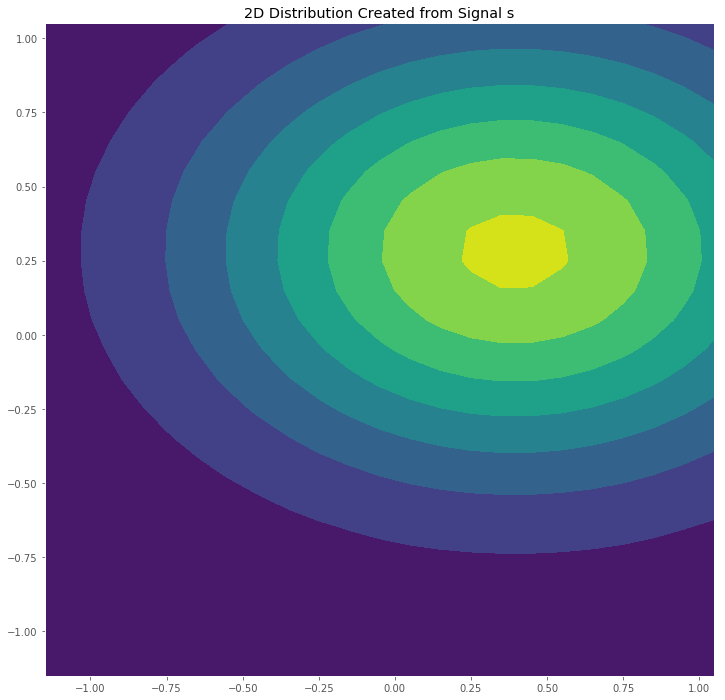

In [9]:
x_grid,y_grid = np.mgrid[-1.15:1.15:0.1, -1.15:1.15:0.1]
pos = np.empty(x_grid.shape + (2,))
pos[:, :, 0] = x_grid
pos[:, :, 1] = y_grid
plt.figure(figsize=(12,12))
plt.contourf(x_grid, y_grid, rv.pdf(pos))
plt.title("2D Distribution Created from Signal s");

Now, we will use a procedure similar to the inverse of the generating discrete action from 2 continuous actions. Here, we are given an action (the output of our model based on a softmax on the final layer) value in $[0,4^N)$. In this scenario, N is the number of controllable joints by the body component being trained. We'll used N = 3.

We will bin the above graph, pick a random possible action, and generate its x and y coordinates. 

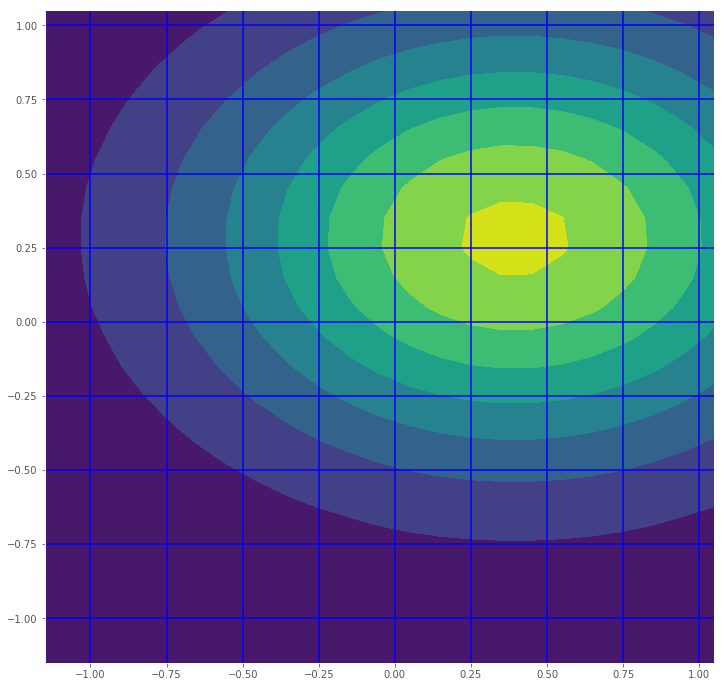

In [12]:
# number of controllable actions
N = 3
# number of bins on each individual axis
r = np.sqrt(4**N)

#create the distribution with grid lines
x_grid,y_grid = np.mgrid[-1.15:1.15:0.1, -1.15:1.15:0.1]
pos = np.empty(x_grid.shape + (2,))
pos[:, :, 0] = x_grid
pos[:, :, 1] = y_grid
plt.figure(figsize=(12,12),facecolor='white')
plt.contourf(x_grid, y_grid, rv.pdf(pos))
# plt.title("Gridded 2D Distribution")
# create the grid lines
for i in range(0, int(r) + 1):
    plt.axvline(x = -1 + 2*i/r, c='blue')
    plt.axhline(y = -1 + 2*i/r, c='blue')
plt.savefig("../../images/grid_dist_sig_s.png")

Action being taken: 21
x,y point = (0.375, -0.375)


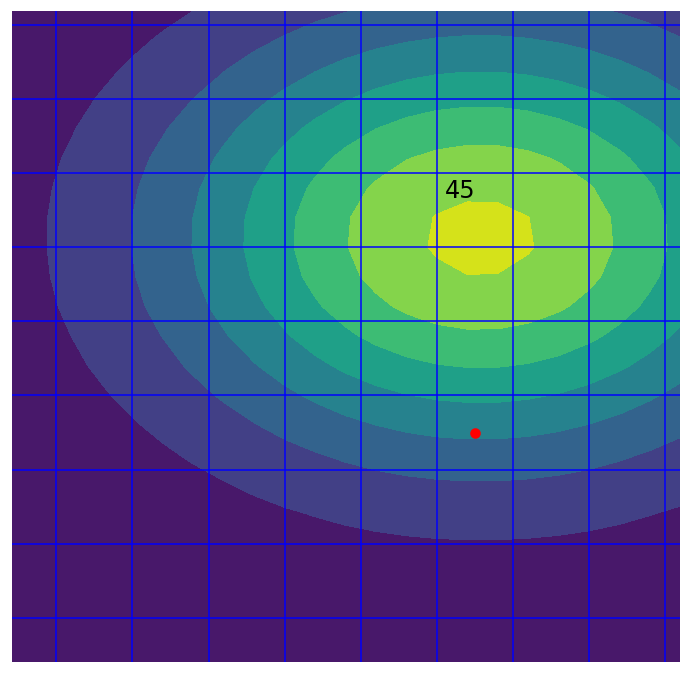

In [17]:
# random possible action
a = np.random.choice(np.arange(0,4**N,1))
# calculated x and y coordinates with some heuristic noise for visualization
x = 2*(a%r)/r - 1 + 0.125
y = 2*(a//r)/r - 1 + 0.125
print("Action being taken: {}".format(a))
print("x,y point = ({:.3f}, {:.3f})".format(x,y))
# plot the grid
plt.figure(figsize=(12,12), facecolor='white')
plt.contourf(x_grid, y_grid, rv.pdf(pos))
# plt.title("Gridded 2D Distribution", fontsize=20)
plt.text(0.275, 0.42, "45", fontsize=24)
# create the grid lines
for i in range(0, int(r) + 1):
    plt.axvline(x = -1 + 2*i/r, c='blue')
    plt.axhline(y = -1 + 2*i/r, c='blue')
plt.scatter(x,y,s=100,color='red')
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
plt.tick_params(
    axis='y',          
    which='both',      
    left=False,      
    labelleft=False);
plt.savefig("../../images/gridded_dist_s2.png");

From this, we can see that the signal wants the model to pick actions closer to 45. We can quantify this want by measuring the probability. After some testing, the final reward function looks like 
$$
    r(s_0) = c_0P(s_0 | \Psi) - c_1
$$
Here, $s_0$ is the x,y coordinate of the point based on the model output and $\Psi$ is the signal. To avoid the situation where the system learns to take advantage of the reward, the point (x,y) is slightly shifted by small random values. Finally, c_0 and c_1 are hyperparameters to control reward function strength. Below, we'll see how this value changes as the action gets closer to the desired action. We've also changed the number of controllable actions to 4.

In [21]:
# plotting function for further testing
def plot_pt(x,y,N=5,visualize=False):
    r = np.sqrt(4**N)
    x_grid,y_grid = np.mgrid[-1.15:1.15:0.1, -1.15:1.15:0.1]
    rv = stats.multivariate_normal(mean=s[0:2], cov=[[abs(s[2]), 0], [0, abs(s[3])]])
    if(visualize):
        x_c = s[0]
        y_c = s[1]
        b_size = 2/r
        bx = ((x_c - (-1))//b_size)
        by = ((y_c- (-1))//b_size)
        center_bin = r*bx + by
        plt.figure(figsize=(12,8))
        plt.text(x_c, y_c, str(center_bin))
        pos = np.empty(x_grid.shape + (2,))
        pos[:,:,0] = x_grid
        pos[:,:,1] = y_grid
        plt.contourf(x_grid,y_grid,rv.pdf(pos))
        plt.scatter(x,y,s=50,color='red')
        for i in range(0, int(r) + 1):
            plt.axvline(x = -1 + 2*i/r, c='blue')
            plt.axhline(y = -1 + 2*i/r, c='blue')
    return 4*np.exp(rv.logpdf([x,y])) - 0.5

Probability of action 37: 1.170


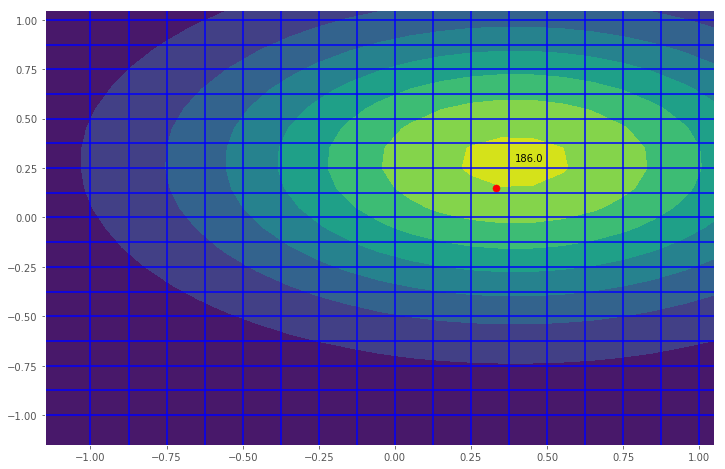

In [22]:
N = 4
x = 2*(37%r)/r - 1 + 0.125 + 0.05*np.random.randn()
y = 2*(37//r)/r - 1 + 0.125 + 0.05*np.random.randn()
print("Probability of action 37: {:.3f}".format(plot_pt(x,y,N,visualize=True)));

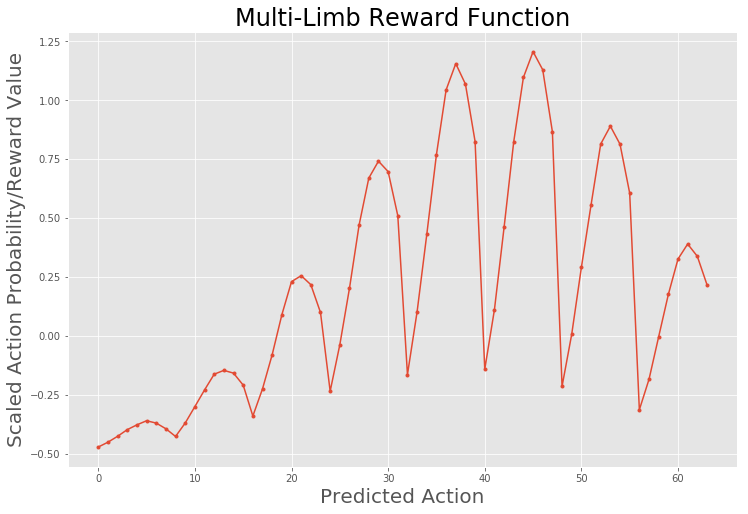

In [24]:
N = 3
r = np.sqrt(4**N)
plot_vals = []
for a in range(0,4**N):
    x = 2*(a%r)/r - 1 + 0.125 + 0.005*np.random.randn()
    y = 2*(a//r)/r - 1 + 0.125 + 0.005*np.random.randn()
    plot_vals.append(plot_pt(x,y,N))
plt.figure(figsize=(12,8), facecolor='white')
plt.plot(plot_vals, '.-')
plt.title("Multi-Limb Reward Function", fontsize=24)
plt.xlabel("Predicted Action", fontsize=20)
plt.ylabel("Scaled Action Probability/Reward Value", fontsize=20)
plt.savefig("../../images/multi_limb_reward_funct.png")


We see that the reward gradually increases the closer to the center of the distribution the predicted action falls. Also, If the predicted action is too far from the chosen distribution, then it becomes negative reversing the direction of learning. Because the signal learned by the higher level changes both the scaling and location of the distribution, then rewards that are on the same line shouldn't necessarily be positively scored. This is why the reward by points close to the center in the vertical axis are scored higher than the points on the horizontal axis.

## Weighted State Features for a Linear Reward Function

One thing we want to know is how the state values affect the reward values for all of the matches. Below, we'll look at how the score changes with regards to some of the state values. This could help us understand maybe understand some aspects of the _true_ reward function. 

In [182]:
df1 = load_csv("../data/player1_state_info.csv")
df2 = load_csv("../data/player2_state_info.csv")
viz1 = visuals("../data/player1_state_info.csv")
viz2 = visuals("../data/player2_state_info.csv")

In [183]:
# we're choosing a specific match because of the interesting movements
viz1.match = 'fastforward.rpl'
#viz1.watch_replay()

In [184]:
leg_joints = ['ankle','hip','knee']
leg_body = ['butt','leg','foot','thigh']
left_leg_positions = np.array([c for c in viz1.positions if c.split('_')[2] in leg_body and 'l' in c])
left_leg_velocities = np.array([c for c in viz1.velocities if c.split('_')[2] in leg_body and 'l' in c])

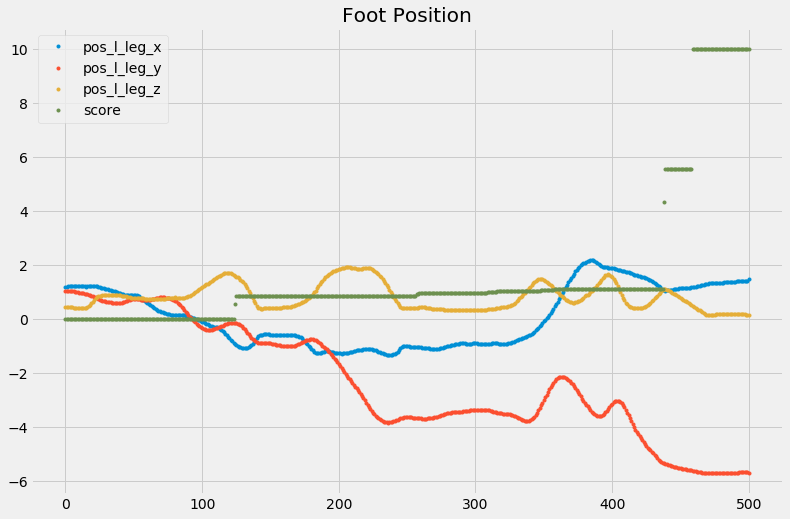

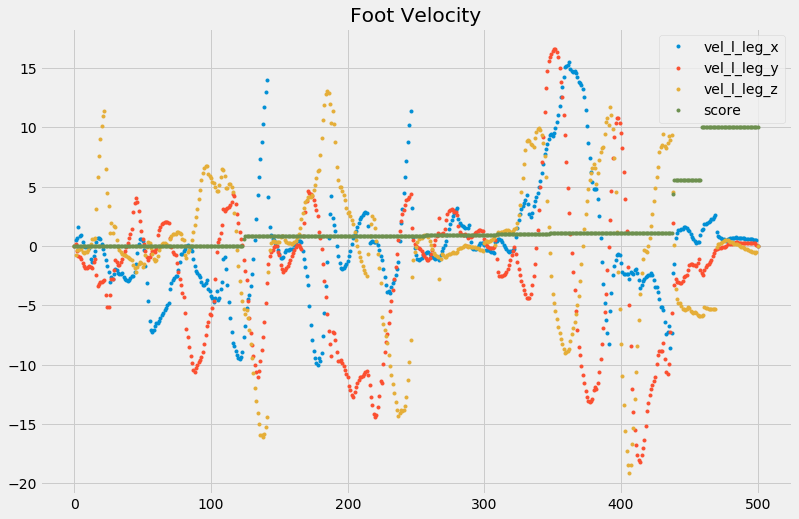

In [185]:
plt.figure(figsize=(12,8))
plt.title("Foot Position")
viz1.plot_column(left_leg_positions[6])
viz1.plot_column(left_leg_positions[7])
viz1.plot_column(left_leg_positions[8])
viz1.plot_column('score')
plt.legend()
plt.figure(figsize=(12,8))
plt.title("Foot Velocity")
viz1.plot_column(left_leg_velocities[6])
viz1.plot_column(left_leg_velocities[7])
viz1.plot_column(left_leg_velocities[8])
viz1.plot_column('score')
plt.legend()

Just from these two graphs alone, it is hard to determine what the potential weights for each of the state values are going to be, but there are some very robust parametric methods we can use to maybe decipher the relationship that exist between reward and state value. 

We will use some penalized linear regression techniques. Essentially this tries to regress the y-value (the score) using a weighted sum of the state values. The weights are subject to a criteria $||w||_p < t$ which, depending on the value of p, can either bring the value of all $w_i$ to, or very close to, zero. 

### Lasso

LASSO, or least absolute shrinkage and selection operator, minimizes the residuals of the output values using the learned weights and the actual outputs while regularizing the weights using a $L_1$ penalty. This will bring the weights on quite a few down to zero. 

In [186]:
# We'll be joining both players dataframes, so let's 
# add some identifiers for the 2nd player
df2_renamed = df2.rename(columns=rename_func)
df1[df2_renamed.columns] = df2_renamed
df1.head()

,Unnamed: 0,act_abs,act_chest,act_left_ankle,act_left_elbow,act_left_glute,act_left_grip,act_left_hip,act_left_knee,act_left_pec,...,vel_r_pecs_z_player_2,vel_r_thigh_x_player_2,vel_r_thigh_y_player_2,vel_r_thigh_z_player_2,vel_r_triceps_x_player_2,vel_r_triceps_y_player_2,vel_r_triceps_z_player_2,vel_stomach_x_player_2,vel_stomach_y_player_2,vel_stomach_z_player_2
0,0,4.0,2.0,4.0,4.0,4.0,2.0,4.0,4.0,4.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
1,1,1.0,1.0,4.0,4.0,4.0,2.0,4.0,4.0,2.0,...,-0.060003,-0.000052,-0.089239,-0.061301,0.002143,0.014553,-0.058735,-8.365150e-10,-0.019239,-0.060351
2,2,1.0,1.0,4.0,4.0,4.0,2.0,4.0,4.0,2.0,...,-0.105831,-0.000191,-0.133514,-0.032161,0.000015,0.053032,-0.110032,-1.550038e-09,-0.033780,-0.075190
3,3,1.0,1.0,4.0,4.0,4.0,2.0,4.0,4.0,2.0,...,-0.140374,-0.000223,-0.162279,-0.019549,-0.000851,0.076721,-0.151805,-2.496145e-09,-0.053143,-0.085010
4,4,1.0,1.0,4.0,4.0,4.0,2.0,4.0,4.0,2.0,...,-0.166898,-0.000228,-0.170159,-0.017809,-0.001059,0.090104,-0.184543,-4.437476e-09,-0.062317,-0.095588


In [187]:
#We're gonna train on score transitions
df1['score_t_next'] = df1['score'].shift()
df1 = df1.dropna()
#drop zero reward transitions
df1 = df1.drop(index = df1[df1['score_t_next'] - df1['score'] == 0].index)
y = df1.score/max(df1.score)
df = df1.drop(columns=[
    'score_t_next',
    'turn', 
    'turn_player_2',
    'Unnamed: 0', 
    'Unnamed: 0_player_2', 
    'match_player_2', 
    'match', 
    'turn_player_2',
    'score',
    'score_player_2'])

In [196]:
print("Number of features being used to predict reward: ",len(df.columns))

Number of features being used to predict reward:  296


In [188]:
X = np.array(df)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)

In [189]:
scores = []
for alp in np.arange(0.00005, 0.01, 0.0005):
    clf1 = linear_model.Lasso(alpha=alp, max_iter=1000)
    clf1.fit(X_train,y_train)
    scores.append(clf1.score(X_test, y_test))

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


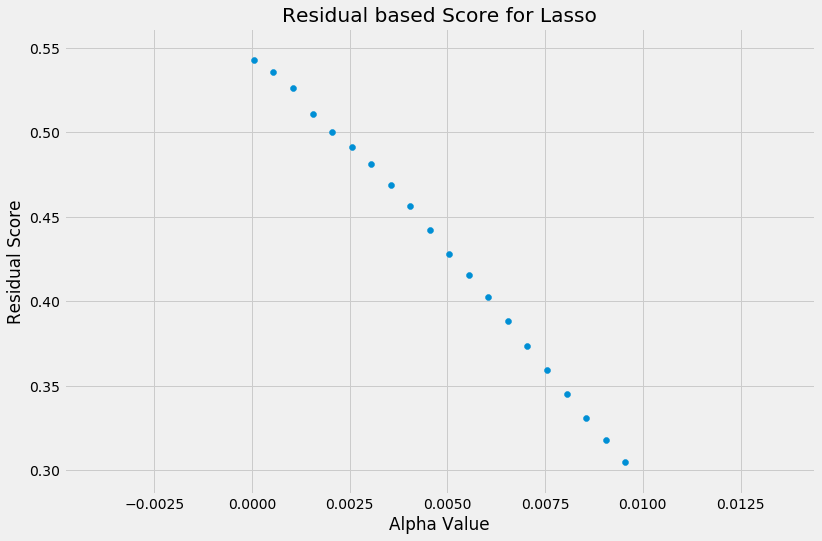

In [190]:
plt.figure(figsize=(12,8))
plt.title("Residual based Score for Lasso")
plt.xlabel("Alpha Value")
plt.ylabel("Residual Score")
plt.scatter(np.arange(0.00005, 0.01, 0.0005), scores)

In [191]:
alp_max = np.arange(0.00005, 0.01, 0.0005)[np.argmax(scores)]

In [192]:
clf1 = linear_model.Lasso(alpha=alp_max, max_iter=100000)
clf1.fit(X_train,y_train)
print("Score: ", clf1.score(X_test, y_test), "with alpha: ", alp_max)

Score:  0.521892503129028 with alpha:  5e-05


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


The scoring measures the ratio of the true residuals to the predicted residuals. A score of 1.0 means that the predicted residuals are 0. If the predicted residuals are less than the true residuals, the score s is $ 1 \leq s \leq 0$. Finally, when the predicted residuals are greater than the true residuals, the score is negative. 

### Ridge Regression

Ridge regression is similar to LASSO but uses a $L_2$ penalty on the weight vector.

In [193]:
scores = []
ran = np.arange(1.0, 10.0, 0.05)
for alp in ran:
    clf1 = linear_model.Ridge(alpha=alp, max_iter=1000)
    clf1.fit(X_train,y_train)
    scores.append(clf1.score(X_test, y_test))

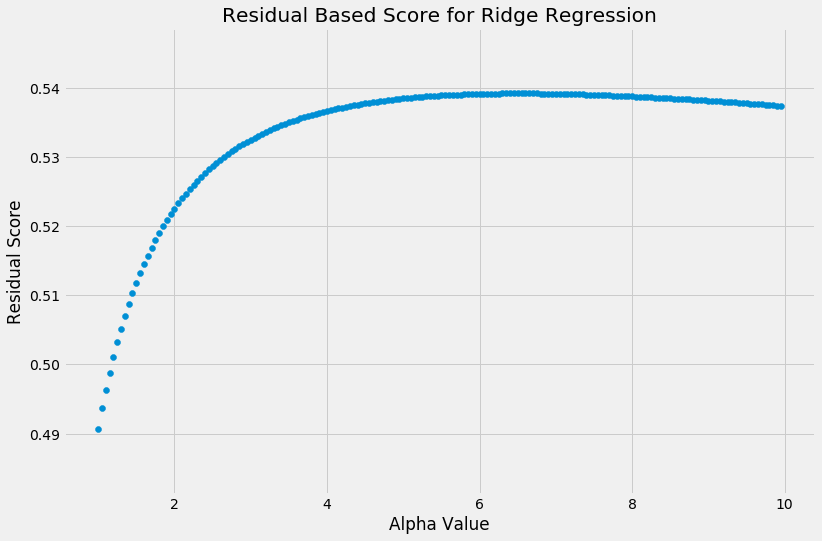

In [194]:
plt.figure(figsize=(12,8))
plt.title("Residual Based Score for Ridge Regression")
plt.xlabel("Alpha Value")
plt.ylabel("Residual Score")
plt.scatter(ran, scores)

In [195]:
alp_max = ran[np.argmax(scores)]
clf1 = linear_model.Ridge(alpha=alp_max, max_iter=1000)
clf1.fit(X_train,y_train)
print("Score: ", clf1.score(X_test, y_test), "with alpha: {:.3f}".format(alp_max))

Score:  0.5392015761689214 with alpha: 6.500


Lasso is much more sensitive to the parameters we are choosing, so our final implementation will only use Ridge Regression.

## Refrences
[1] Nechyba, Michael C., and Yangsheng Xu. "Stochastic similarity for validating human control strategy models." IEEE Transactions on Robotics and Automation 14.3 (1998): 437-451.